
# A Notebook to analyze downloaded gridded climate time-series data 

## (Case study:  the Sauk-Suiattle Watershed )
<img src= "http://www.sauk-suiattle.com/images/Elliott.jpg"
style="float:left;width:150px;padding:20px">   
This data is compiled to digitally observe the Sauk-Suiattle Watershed, powered by HydroShare. <br />
<br />
Use this Jupyter Notebook to: <br />
Migrate data sets from prior data download events,
Compute daily, monthly, and annual temperature and precipitation statistics, <br /> 
Visualize precipitation results relative to the forcing data, <br />
Visualize the time-series trends among the gridded cells using different Gridded data products. <br />

<br /> <br /> <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:20px">  
#### A Watershed Dynamics Model by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington 

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [ ]:
#conda install -c conda-forge basemap-data-hires --yes

In [5]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh
import geopandas as gpd

# data migration library
from utilities import hydroshare

# plotting and shape libraries
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

# # spatial plotting
# import fiona
# import shapely.ops
# from shapely.geometry import MultiPolygon, shape, point, box, Polygon
# from descartes import PolygonPatch
# from matplotlib.collections import PatchCollection
# from mpl_toolkits.basemap import Basemap

In [6]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [7]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [8]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 7c3416535ab24d4f93b0b94741bb9572
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/7c3416535ab24d4f93b0b94741bb9572/7c3416535ab24d4f93b0b94741bb9572/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the Sauk-Suiattle Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [9]:
"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhuc12_17110006_WGS84.shp']

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


KeyError: 'wbdhuc12_17110006_WGS84.shp'

### Summarize the file availability from each watershed mapping file

In [10]:
# map the mappingfiles from usecase1
mappingfile1 = os.path.join(homedir,'Sauk_mappingfile.csv')
mappingfile2 = os.path.join(homedir,'Elwha_mappingfile.csv')
mappingfile3 = os.path.join(homedir,'RioSalado_mappingfile.csv')

t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1, mappingfile2, mappingfile3], 
                            listofwatershednames = ['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                            meta_file=meta_file)

t1

Watershed,Sauk-Suiattle river,Elwha river,Upper Rio Salado
Median elevation in meters [range](No. gridded cells),1171[164-2216] (n=99),1120[36-1642] (n=55),2308[1962-2669] (n=31)
dailymet_bclivneh2013,1171[164-2216] (n=99),1120[36-1642] (n=55),0
dailymet_livneh2013,1171[164-2216] (n=99),1146[174-1642] (n=52),2308[1962-2669] (n=31)
dailymet_livneh2015,1171[164-2216] (n=99),1120[36-1642] (n=55),2308[1962-2669] (n=31)
dailyvic_livneh2013,1171[164-2216] (n=99),1146[174-1642] (n=52),2308[1962-2669] (n=31)
dailyvic_livneh2015,1171[164-2216] (n=99),1120[36-1642] (n=55),2308[1962-2669] (n=31)
dailywrf_bcsalathe2014,1171[164-2216] (n=99),1142[97-1642] (n=53),0
dailywrf_salathe2014,1171[164-2216] (n=99),1142[97-1642] (n=53),0


## 3.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013, Livneh 2016, and WRF 2014 temperature and precipitation data in order to compare them with each other and observations. The generated plots are automatically downloaded and saved as .png files in the "plots" folder of the user's home directory and inline in the notebook.

In [11]:
# Livneh et al., 2013
dr1 = meta_file['dailymet_livneh2013']

# Salathe et al., 2014
dr2 = meta_file['dailywrf_salathe2014']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

('1950-01-01', '2010-12-31')

### INPUT: gridded meteorology from Jupyter Hub folders
Data frames for each set of data are stored in a dictionary. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>  

#### Create a dictionary of climate variables for the long-term mean (ltm) using the default elevation option of calculating a high, mid, and low elevation average.  The dictionary here is initialized with the Livneh et al., 2013 dataset with a dictionary output 'ltm_3bands', which is used as an input to the second time we run gridclim_dict(), to add the Salathe et al., 2014 data to the same dictionary. 

In [12]:
%%time
ltm_3bands = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

Number of data files within elevation range (164.0:2216.0): 99
PRECIP dataframe reading to start: 0:00:00.151674
PRECIP dataframe complete:0:00:01.435160
TMAX dataframe reading to start: 0:00:01.585947
TMAX dataframe complete:0:00:02.593651
TMIN dataframe reading to start: 0:00:02.742795
TMIN dataframe complete:0:00:03.851551
WINDSPD dataframe reading to start: 0:00:04.010129
WINDSPD dataframe complete:0:00:05.004885
PRECIP_dailymet_livneh2013 calculations completed in 0:00:00.099236
TMAX_dailymet_livneh2013 calculations completed in 0:00:00.076262
TMIN_dailymet_livneh2013 calculations completed in 0:00:00.076580
WINDSPD_dailymet_livneh2013 calculations completed in 0:00:00.075123
CPU times: user 12.8 s, sys: 2.68 s, total: 15.5 s
Wall time: 5.35 s


In [13]:
%%time
ltm_3bands = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailyvic_livneh2013',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_3bands)

Number of data files within elevation range (164.0:2216.0): 99
EVAP dataframe reading to start: 0:00:00.153842
EVAP dataframe complete:0:00:01.392438
RUNOFF dataframe reading to start: 0:00:01.542447
RUNOFF dataframe complete:0:00:02.656092
BASEFLOW dataframe reading to start: 0:00:02.806844
BASEFLOW dataframe complete:0:00:03.898230
SMTOP dataframe reading to start: 0:00:04.056814
SMTOP dataframe complete:0:00:05.160566
SMMID dataframe reading to start: 0:00:05.311674
SMMID dataframe complete:0:00:06.408413
SMBOT dataframe reading to start: 0:00:06.557697
SMBOT dataframe complete:0:00:07.775956
SWE dataframe reading to start: 0:00:07.927947
SWE dataframe complete:0:00:09.038978
WDEW dataframe reading to start: 0:00:09.187258
WDEW dataframe complete:0:00:10.289675
SENSIBLE dataframe reading to start: 0:00:10.440184
SENSIBLE dataframe complete:0:00:11.513842
LATENT dataframe reading to start: 0:00:11.664405
LATENT dataframe complete:0:00:12.739798
GRNDFLUX dataframe reading to start: 0:

In [17]:
sorted(ltm_3bands.keys())

['BASEFLOW_dailyvic_livneh2013',
 'EVAP_dailyvic_livneh2013',
 'GRNDFLUX_dailyvic_livneh2013',
 'LATENT_dailyvic_livneh2013',
 'PRECIP_dailymet_livneh2013',
 'PREC_dailyvic_livneh2013',
 'RADTEMP_dailyvic_livneh2013',
 'RNET_dailyvic_livneh2013',
 'RUNOFF_dailyvic_livneh2013',
 'SENSIBLE_dailyvic_livneh2013',
 'SMBOT_dailyvic_livneh2013',
 'SMMID_dailyvic_livneh2013',
 'SMTOP_dailyvic_livneh2013',
 'STREAMFLOW_dailyvic_livneh2013',
 'SWE_dailyvic_livneh2013',
 'TMAX_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013',
 'WDEW_dailyvic_livneh2013',
 'WINDSPD_dailymet_livneh2013',
 'anom_year_BASEFLOW_dailyvic_livneh2013',
 'anom_year_EVAP_dailyvic_livneh2013',
 'anom_year_GRNDFLUX_dailyvic_livneh2013',
 'anom_year_LATENT_dailyvic_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PREC_dailyvic_livneh2013',
 'anom_year_RADTEMP_dailyvic_livneh2013',
 'anom_year_RNET_dailyvic_livneh2013',
 'anom_year_RUNOFF_dailyvic_livneh2013',
 'anom_year_SENSIBLE_dailyvic_livneh2013',
 'anom

In [19]:
ltm_3bands['STREAMFLOW_dailyvic_livneh2013']=ltm_3bands['BASEFLOW_dailyvic_livneh2013']+ltm_3bands['RUNOFF_dailyvic_livneh2013']
ltm_3bands['STREAMFLOW_dailyvic_livneh2013']

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
,48.53125,48.46875,48.46875,48.46875,48.46875,48.40625,48.40625,48.40625,48.40625,48.40625,...,47.96875,47.96875,47.96875,47.96875,47.96875,47.96875,47.96875,47.90625,47.90625,47.90625
,-121.59375,-121.46875,-121.53125,-121.59375,-121.65625,-121.09375,-121.15625,-121.21875,-121.28125,-121.34375,...,-121.15625,-121.21875,-121.28125,-121.34375,-121.40625,-121.46875,-121.53125,-121.28125,-121.34375,-121.40625
1950-01-01,0.000026,0.000022,0.000014,0.000012,0.000034,0.000019,0.000018,0.000023,0.000014,0.000025,...,0.000014,0.000019,0.000020,0.000015,0.000025,0.000024,0.000030,0.000024,0.000024,0.000025
1950-01-02,0.000025,0.000021,0.000014,0.000012,0.000034,0.000019,0.000017,0.000023,0.000014,0.000025,...,0.000014,0.000019,0.000020,0.000015,0.000025,0.000023,0.000029,0.000023,0.000024,0.000025
1950-01-03,0.000025,0.000021,0.000014,0.000012,0.000033,0.000019,0.000017,0.000022,0.000014,0.000024,...,0.000013,0.000019,0.000019,0.000015,0.000024,0.000023,0.000028,0.000023,0.000023,0.000024
1950-01-04,0.000024,0.000021,0.000014,0.000012,0.000033,0.000018,0.000017,0.000022,0.000014,0.000024,...,0.000013,0.000019,0.000019,0.000015,0.000024,0.000022,0.000028,0.000022,0.000023,0.000024
1950-01-05,0.000024,0.000020,0.000014,0.000012,0.000032,0.000018,0.000017,0.000021,0.000014,0.000023,...,0.000013,0.000018,0.000019,0.000015,0.000023,0.000022,0.000027,0.000022,0.000023,0.000024
1950-01-06,0.000023,0.000020,0.000014,0.000012,0.000032,0.000018,0.000016,0.000021,0.000014,0.000023,...,0.000013,0.000018,0.000018,0.000015,0.000023,0.000021,0.000027,0.000022,0.000022,0.000023
1950-01-07,0.000023,0.000020,0.000014,0.000012,0.000031,0.000018,0.000016,0.000020,0.000014,0.000022,...,0.000013,0.000018,0.000018,0.000015,0.000022,0.000021,0.000026,0.000021,0.000022,0.000023
1950-01-08,0.000022,0.000019,0.000014,0.000012,0.000030,0.000017,0.000016,0.000020,0.000014,0.000022,...,0.000013,0.000018,0.000018,0.000014,0.000022,0.000021,0.000026,0.000021,0.000022,0.000022


In [21]:
"""
Sauk-Suiattle
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

"""
Elwha
"""
# Watershed extent
hs.getResourceFromHydroShare('4aff8b10bc424250b3d7bac2188391e8', )
elwha = hs.content["elwha_ws_bnd_wgs84.shp"]

"""
Upper Rio Salado
"""
# Watershed extent
hs.getResourceFromHydroShare('5c041d95ceb64dce8eb85d2a7db88ed7')
riosalado = hs.content['UpperRioSalado_delineatedBoundary.shp']

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


In [41]:
s1 = gpd.read_file(shapefile)
s1['watershed']='watershed'
s1 = s1.dissolve(by='watershed')

0     0.003906
1     0.003906
2     0.003906
3     0.003906
4     0.003906
5     0.003906
6     0.003906
7     0.003906
8     0.003906
9     0.003906
10    0.003906
11    0.003906
12    0.003906
13    0.003906
14    0.003906
15    0.003906
16    0.003906
17    0.003906
18    0.003906
19    0.003906
20    0.003906
21    0.003906
22    0.003906
23    0.003906
24    0.003906
25    0.003906
26    0.003906
27    0.003906
28    0.003906
29    0.003906
        ...   
69    0.003906
70    0.003906
71    0.003906
72    0.003906
73    0.003906
74    0.003906
75    0.003906
76    0.003906
77    0.003906
78    0.003906
79    0.003906
80    0.003906
81    0.003906
82    0.003906
83    0.003906
84    0.003906
85    0.003906
86    0.003906
87    0.003906
88    0.003906
89    0.003906
90    0.003906
91    0.003906
92    0.003906
93    0.003906
94    0.003906
95    0.003906
96    0.003906
97    0.003906
98    0.003906
dtype: float64

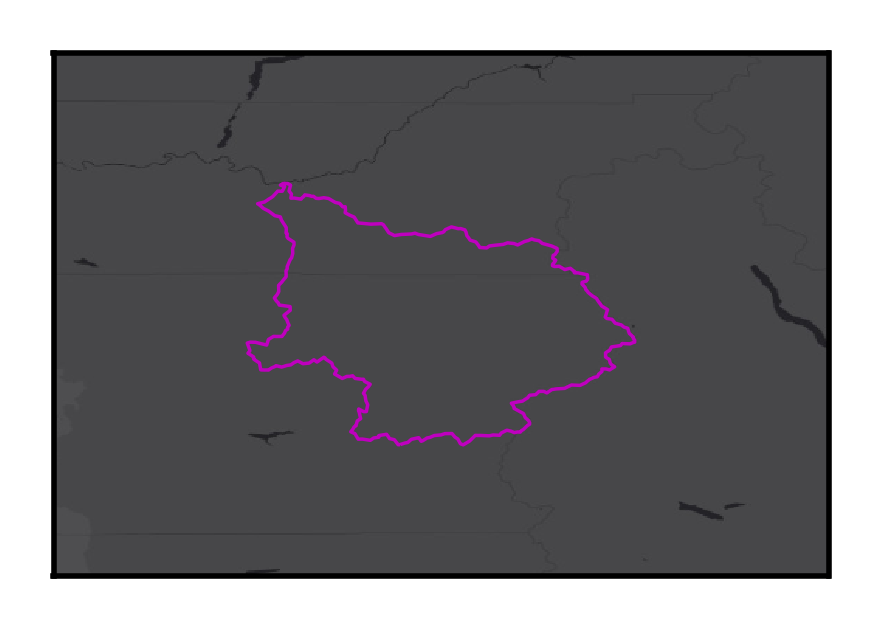

In [55]:
# generate surface area for each gridded cell

# params
shapefile = sauk
spatial_resolution=1/16
margin=0.5
basemap_image='Canvas/World_Dark_Gray_Base'
vardf = ltm_3bands['STREAMFLOW_dailyvic_livneh2013']
epsg=4326

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# spatial plotting
import fiona
import shapely.ops
from shapely.geometry import MultiPolygon, shape, point, box, Polygon
from mpl_toolkits.basemap import Basemap


# generate the figure axis
fig = plt.figure(figsize=(2,2), dpi=500)
ax1 = plt.subplot2grid((1,1),(0,0))

# calculate bounding box based on the watershed shapefile
watershed = gpd.read_file(shapefile)
watershed['watershed']='watershed'
watershed = watershed.dissolve(by='watershed')
lon0, lat0 = np.array(watershed.centroid.iloc[0])
minx, miny, maxx, maxy = watershed.bounds.iloc[0]
w, h = maxx - minx, maxy - miny


# generate basemap
m = Basemap(projection='tmerc', epsg=epsg, resolution='h', ax=ax1, lat_0=lat0, lon_0=lon0,
            llcrnrlon=minx-margin*w, llcrnrlat=miny-margin*h, urcrnrlon=maxx+margin*w, urcrnrlat=maxy+margin*h)
m.arcgisimage(service=basemap_image, xpixels=500)

# watershed
m.readshapefile(shapefile=shapefile.replace('.shp',''), name='watershed', drawbounds=True, color='m')

# variable dataframe
midpt=spatial_resolution/2
crs={'init':'epsg:{0}'.format(epsg)}
cat=vardf.T.reset_index(level=[1,2]).rename(columns={'level_1':'LAT','level_2':'LONG_'})
geometry = cat.apply(lambda x: 
                     shapely.ops.transform(m, box(x['LONG_']-midpt, x['LAT']-midpt,
                                                  x['LONG_']+midpt, x['LAT']+midpt)), axis=1)
geo_area = geometry.apply(lambda x: x.area)
geo_area

In [ ]:
geo_area.mean()*10**12

In [ ]:
# convert mm/s to m/s
df_dict = ltm_3bands
objname = 'STREAMFLOW_dailyvic_livneh2013'
dataset = objname.split('_',1)[1]
gridcell_area = geo_area
exceedance = 10



# convert mmps to mps
mmps = df_dict[objname]
mps = mmps*0.001

# multiply streamflow (mps) with grid cell surface area (m2) to produce volumetric streamflow (cms)
cms = mps.multiply(np.array(geo_area))

# convert m^3/s to cfs; multiply with (3.28084)^3
cfs = cms.multiply((3.28084)**3)

# output to df_dict
df_dict['cfs_'+objname] = cfs

# time-group by month-yearly streamflow volumetric values
monthly_cfs = cfs.groupby(pd.TimeGrouper('M')).sum()
monthly_cfs.index = pd.Series(monthly_cfs.index).apply(lambda x: x.strftime('%Y-%m'))

# output to df_dict
df_dict['monthly_cfs_'+objname] = monthly_cfs




# prepare for Exceedance computations
row_indices = pd.Series(monthly_cfs.index).map(lambda x: pd.datetime.strptime(x, '%Y-%m').month)
months = range(1,13)
Exceed = pd.DataFrame()

# for each month
for eachmonth in months:
    month_index = row_indices[row_indices==eachmonth].index
    month_res = monthly_cfs.iloc[month_index,:].reset_index(drop=True)

    # generate gridded-cell-specific 10% exceedance probability values
    exceed = pd.DataFrame(month_res.apply(lambda x: np.percentile(x, 0.90), axis=0)).T
    
    # append to dataframe
    Exceed = pd.concat([Exceed, exceed])
    
# set index to month order
Exceed = Exceed.set_index(np.array(months))

# output to df_dict
df_dict['EXCEED{0}_{1}'.format(exceedance,dataset)] = Exceed

# return(df_dict)

In [ ]:
def monthlyExceedence_cfs (df_dict,
                           daily_streamflow_dfname,
                           gridcell_area,
                           exceedance=10,
                           start_date=None,
                           end_date=None):
    
    """
    streamflow_df: (dataframe) streamflow values in cubic feet per second (row_index: date, col_index: gridcell ID)
    daily_baseflow_df: (dataframe) groundwater flow in cubic feet per second (row_index: date, col_index: gridcell ID)
    daily_surfacerunoff_df: (dateframe) surface flow in cubic feet per second (row_index: date, col_index: gridcell ID)
    start_date: (datetime) start date
    end_date: (datetime) end date
    """
    
    #daily_baseflow_df=None, #'BASEFLOW_dailyvic_livneh2013', 
    #daily_surfacerunoff_df=None, #'RUNOFF_dailyvic_livneh2013',

    ## aggregate each daily streamflow value to a month-yearly sum
    mmps = df_dict[daily_streamflow_dfname]
    ## subset daily streamflow_df to that index range
    if isinstance(start_date, type(None)):
        startyear=0
    if isinstance(end_date, type(None)):
        endyear=len(mmps)-1
    mmps = mmps.iloc[start_date:end_date,:]
    
    # convert mmps to mps
    mps = mmps*0.001

    # multiply streamflow (mps) with grid cell surface area (m2) to produce volumetric streamflow (cms)
    cms = mps.multiply(np.array(geo_area))

    # convert m^3/s to cfs; multiply with (3.28084)^3
    cfs = cms.multiply((3.28084)**3)

    # output to df_dict
    df_dict['cfs_'+objname] = cfs

    # time-group by month-yearly streamflow volumetric values
    monthly_cfs = cfs.groupby(pd.TimeGrouper('M')).sum()
    monthly_cfs.index = pd.Series(monthly_cfs.index).apply(lambda x: x.strftime('%Y-%m'))

    # output to df_dict
    df_dict['monthly_cfs_'+objname] = monthly_cfs

    
    monthly_streamflow_df = daily_streamflow_df.groupby(pd.TimeGrouper("M")).sum()
    
    # loop through each station
    
    for eachcol in monthly_streamflow_df.columns():
        station_moyr = dask.delayed(monthly_streamflow_df.loc[:,eachcol])
        station_moyr
        
        
df_dict = ltm_3bands
objname = 'STREAMFLOW_dailyvic_livneh2013'
dataset = objname.split('_',1)[1]
gridcell_area = geo_area
exceedance = 10

ltm_3bands['STREAMFLOW_dailyvic_livneh2013']=ltm_3bands['BASEFLOW_dailyvic_livneh2013']+ltm_3bands['RUNOFF_dailyvic_livneh2013']
        
#         function [Qex] = monthlyExceedence_cfs(file,startyear,endyear)
# % Load data from specified file
# data = load(file);
# Y=data(:,1);
# MO=data(:,2);
# D=data(:,3);
# t = datenum(Y,MO,D);
# %%%
# % startyear=data(1,1);
# % endyear=data(length(data),1);

# Qnode = data(:,4);

# %  Time control indices that cover selected period
# d_start = datenum(startyear,10,01,23,0,0); % 1 hour early to catch record for that day
# d_end = datenum(endyear,09,30,24,0,0); 
# idx = find(t>=d_start & t<=d_end);

# exds=(1:19)./20;  % Exceedence probabilities from 0.05 to 0.95
# mos=[10,11,12,1:9];
# Qex(1:19,1:12)=0 ; % initialize array
# for imo=1:12;
#     mo=mos(imo);
#     [Y, M, D, H, MI, S] = datevec(t(idx));
#     ind=find(M==mo);  % find all flow values in that month in the period identified
#     Q1=Qnode(idx(ind)); % input is in cfs
#     for iex=1:19
#         Qex(iex,imo)=quantile(Q1,1-exds(iex));
#     end
# end


# end


In [ ]:
ltm_3bands['cfs_STREAMFLOW_dailyvic_livneh2013']

In [ ]:
ltm_3bands['monthly_cfs_STREAMFLOW_dailyvic_livneh2013']

In [ ]:
ltm_3bands['EXCEED10_dailyvic_livneh2013']

In [ ]:
# loop through each month to compute the 10% Exceedance Probability
for eachmonth in range(1,13):
    monthlabel = pd.datetime.strptime(str(eachmonth), '%m')

    ogh.renderValuesInPoints(vardf=ltm_3bands['EXCEED10_dailyvic_livneh2013'],
                             vardf_dateindex=eachmonth, 
                             shapefile=sauk.replace('.shp','_2.shp'),
                             outfilepath='sauk{0}exceed10.png'.format(monthlabel.strftime('%b')), 
                             plottitle='Sauk {0} 10% Exceedance Probability'.format(monthlabel.strftime('%B')),
                             colorbar_label='cubic feet per second',
                             cmap='seismic_r')

## 4. Visualize monthly precipitation spatially using Livneh et al., 2013 Meteorology data

### Apply different plotting options:

time-index option <br />
Basemap option <br />
colormap option <br />
projection option <br />

In [ ]:
%%time

month=3
monthlabel = pd.datetime.strptime(str(month), '%m')
ogh.renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='Demographics/USA_Social_Vulnerability_Index',
                         cmap='gray_r')

month=6
monthlabel = pd.datetime.strptime(str(month), '%m')
ogh.renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='ESRI_StreetMap_World_2D',
                         cmap='gray_r')

month=9
monthlabel = pd.datetime.strptime(str(month), '%m')
ogh.renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='ESRI_Imagery_World_2D',
                         cmap='gray_r')

month=12
monthlabel = pd.datetime.strptime(str(month), '%m')
ogh.renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

### Visualize monthly precipitation difference between different gridded data products

In [ ]:
for month in [3, 6, 9, 12]:
    monthlabel = pd.datetime.strptime(str(month), '%m')
    outfile='SaukLivnehPrecip{0}.png'.format(monthlabel.strftime('%b'))
    
    ax1 = ogh.renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailymet_livneh2013'],
                                   vardf_dateindex=month,
                                   shapefile=sauk.replace('.shp','_2.shp'), 
                                   basemap_image='ESRI_Imagery_World_2D',
                                   cmap='seismic_r',
                                   plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+monthlabel.strftime('%B'),
                                   colorbar_label='Average monthly precipitation (meters)',
                                   outfilepath=os.path.join(homedir, outfile))

## comparison to WRF data from Salathe et al., 2014

In [ ]:
%%time
ltm_3bands = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailywrf_salathe2014',
                               colvar=None,
                               file_start_date=dr2['start_date'], 
                               file_end_date=dr2['end_date'],
                               file_time_step=dr2['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_3bands)

In [ ]:
for month in [3, 6, 9, 12]:
    monthlabel = pd.datetime.strptime(str(month), '%m')
    outfile='SaukSalathePrecip{0}.png'.format(monthlabel.strftime('%b'))
    
    ax1 = ogh.renderValuesInPoints(vardf=ltm_3bands['month_PRECIP_dailywrf_salathe2014'],
                                   vardf_dateindex=month,
                                   shapefile=sauk.replace('.shp','_2.shp'), 
                                   basemap_image='ESRI_Imagery_World_2D',
                                   cmap='seismic_r',
                                   plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+monthlabel.strftime('%B'),
                                   colorbar_label='Average monthly precipitation (meters)',
                                   outfilepath=os.path.join(homedir, outfile))

In [ ]:
def plot_meanTmin(dictionary, loc_name, start_date, end_date):
    # Plot 1: Monthly temperature analysis of Livneh data
    if 'meanmonth_temp_min_liv2013_met_daily' and 'meanmonth_temp_min_wrf2014_met_daily' not in dictionary.keys():
        pass

    # generate month indices
    wy_index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    wy_numbers=[10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    month_strings=[ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept']
    
    # initiate the plot object
    fig, ax=plt.subplots(1,1,figsize=(10, 6))

    if 'meanmonth_temp_min_liv2013_met_daily' in dictionary.keys():
        # Liv2013

        plt.plot(wy_index, dictionary['meanmonth_temp_min_liv2013_met_daily'][wy_numbers],'r-', linewidth=1, label='Liv Temp min')  
    
    if 'meanmonth_temp_min_wrf2014_met_daily' in dictionary.keys():
        # WRF2014
        plt.plot(wy_index, dictionary['meanmonth_temp_min_wrf2014_met_daily'][wy_numbers],'b-',linewidth=1, label='WRF Temp min')
 
    if 'meanmonth_temp_min_livneh2013_wrf2014bc_met_daily' in dictionary.keys():
        # WRF2014
        plt.plot(wy_index, dictionary['meanmonth_temp_min_livneh2013_wrf2014bc_met_daily'][wy_numbers],'g-',linewidth=1, label='WRFbc Temp min')
 
    # add reference line at y=0
    plt.plot([1, 12],[0, 0], 'k-',linewidth=1)

    plt.ylabel('Temp (C)',fontsize=14)
    plt.xlabel('Month',fontsize=14)
    plt.xlim(1,12);
    plt.xticks(wy_index, month_strings);
        
    plt.tick_params(labelsize=12)
    plt.legend(loc='best')
    plt.grid(which='both')
    plt.title(str(loc_name)+'\nMinimum Temperature\n Years: '+str(start_date.year)+'-'+str(end_date.year)+'; Elevation: '+str(dictionary['analysis_elev_min'])+'-'+str(dictionary['analysis_elev_max'])+'m', fontsize=16)
    plt.savefig('monthly_Tmin'+str(loc_name)+'.png')
    plt.show()

# 6. Compare gridded model to point observations

### Read in  SNOTEL data - assess available data 
If you want to plot observed snotel point precipitation or temperature with the gridded climate data, set to 'Y' 
Give name of Snotel file and name to be used in figure legends. 
File format: Daily SNOTEL Data Report - Historic - By individual SNOTEL site, standard sensors (https://www.wcc.nrcs.usda.gov/snow/snotel-data.html)

In [ ]:
# Sauk
SNOTEL_file = os.path.join(homedir,'ThunderBasinSNOTEL.txt')
SNOTEL_station_name='Thunder Creek'
SNOTEL_file_use_colsnames = ['Date','Air Temperature Maximum (degF)', 'Air Temperature Minimum (degF)','Air Temperature Average (degF)','Precipitation Increment (in)']
SNOTEL_station_elev=int(4320/3.281) # meters

SNOTEL_obs_daily = ogh.read_daily_snotel(file_name=SNOTEL_file, 
                                         usecols=SNOTEL_file_use_colsnames,
                                         delimiter=',', 
                                         header=58)

# generate the start and stop date
SNOTEL_obs_start_date=SNOTEL_obs_daily.index[0]
SNOTEL_obs_end_date=SNOTEL_obs_daily.index[-1]

# peek
SNOTEL_obs_daily.head(5)

### Read in  COOP station data - assess available data
https://www.ncdc.noaa.gov/

In [ ]:
COOP_file=os.path.join(homedir, 'USC00455678.csv') # Sauk
COOP_station_name='Mt Vernon'
COOP_file_use_colsnames = ['DATE','PRCP','TMAX', 'TMIN','TOBS']
COOP_station_elev=int(4.3) # meters

COOP_obs_daily = ogh.read_daily_coop(file_name=COOP_file,
                                     usecols=COOP_file_use_colsnames,
                                     delimiter=',',
                                     header=0)

# generate the start and stop date
COOP_obs_start_date=COOP_obs_daily.index[0]
COOP_obs_end_date=COOP_obs_daily.index[-1]

# peek
COOP_obs_daily.head(5)

In [ ]:
#initiate new dictionary with original data
ltm_0to3000 = ogh.gridclim_dict(metadata=meta_file,
                                mappingfile=mappingfile1,
                                dataset='dailymet_livneh2013',
                                file_start_date=dr1['start_date'], 
                                file_end_date=dr1['end_date'], 
                                subset_start_date=dr[0],
                                subset_end_date=dr[1])

ltm_0to3000 = ogh.gridclim_dict(metadata=meta_file,
                                mappingfile=mappingfile1,
                                dataset='dailywrf_salathe2014',
                                file_start_date=dr2['start_date'], 
                                file_end_date=dr2['end_date'], 
                                subset_start_date=dr[0],
                                subset_end_date=dr[1],
                                df_dict=ltm_0to3000)

sorted(ltm_0to3000.keys())

In [ ]:
# read in the mappingfile
mappingfile = mappingfile1

mapdf = pd.read_csv(mappingfile)

# select station by first FID
firstStation = ogh.findStationCode(mappingfile=mappingfile, colvar='FID', colvalue=0)

# select station by elevation
maxElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].max())
medElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].median())
minElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].min())


# print(firstStation, mapdf.iloc[0].ELEV)
# print(maxElevStation, mapdf.loc[:,'ELEV'].max())
# print(medElevStation, mapdf.loc[:,'ELEV'].median())
# print(minElevStation, mapdf.loc[:,'ELEV'].min())

# let's compare monthly averages for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['month_TMAX_dailymet_livneh2013',
        'month_TMAX_dailywrf_salathe2014']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey]

panel_obj = pd.Panel.from_dict(obj)
panel_obj

In [ ]:
comp = ['meanmonth_TMAX_dailymet_livneh2013',
        'meanmonth_TMAX_dailywrf_salathe2014']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey]

        df_obj = pd.DataFrame.from_dict(obj)
df_obj

In [ ]:
t_res, var, dataset, pub = each.rsplit('_',3)

print(t_res, var, dataset, pub)

In [ ]:
ylab_var = meta_file['_'.join([dataset, pub])]['variable_info'][var]['desc']
ylab_unit = meta_file['_'.join([dataset, pub])]['variable_info'][var]['units']

print('{0} {1} ({2})'.format(t_res, ylab_var, ylab_unit))

In [ ]:
%%time
comp = [['meanmonth_TMAX_dailymet_livneh2013','meanmonth_TMAX_dailywrf_salathe2014'],
        ['meanmonth_PRECIP_dailymet_livneh2013','meanmonth_PRECIP_dailywrf_salathe2014']]
wy_numbers=[10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
month_strings=[ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']


fig = plt.figure(figsize=(20,5), dpi=500)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)


# monthly
for eachsumm in df_obj.columns:
    ax1.plot(df_obj[eachsumm])
    

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2, fontsize=10)
plt.show()

In [ ]:
df_obj[each].index.apply(lambda x: x+2)

In [ ]:
fig, ax = plt.subplots()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()
    

    
    
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), 
                 axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()

## Set up VIC dictionary (as an example)  to compare to available data

In [ ]:
vic_dr1 = meta_file['dailyvic_livneh2013']['date_range']
vic_dr2 = meta_file['dailyvic_livneh2015']['date_range']
vic_dr = ogh.overlappingDates(tuple([vic_dr1['start'], vic_dr1['end']]),
                              tuple([vic_dr2['start'], vic_dr2['end']]))

vic_ltm_3bands = ogh.gridclim_dict(mappingfile=mappingfile,
                                   metadata=meta_file,
                                   dataset='dailyvic_livneh2013',
                                   file_start_date=vic_dr1['start'], 
                                   file_end_date=vic_dr1['end'],
                                   file_time_step=vic_dr1['time_step'],
                                   subset_start_date=vic_dr[0],
                                   subset_end_date=vic_dr[1])

In [ ]:
sorted(vic_ltm_3bands.keys())

## 10. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [ ]:
#execute this cell to list the content of the directory
!ls -lt

Create list of files to save to HydroShare. Verify location and names.

In [ ]:
!tar -zcf {climate2013_tar} livneh2013
!tar -zcf {climate2015_tar} livneh2015
!tar -zcf {wrf_tar} salathe2014

In [ ]:
ThisNotebook='Observatory_Sauk_TreatGeoSelf.ipynb' #check name for consistency
climate2013_tar = 'livneh2013.tar.gz'
climate2015_tar = 'livneh2015.tar.gz'
wrf_tar = 'salathe2014.tar.gz'
mappingfile = 'Sauk_mappingfile.csv'

files=[ThisNotebook, mappingfile, climate2013_tar, climate2015_tar, wrf_tar]

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Results from testing out the TreatGeoSelf utility'
abstract = 'This the output from the TreatGeoSelf utility integration notebook.'
keywords = ['Sauk', 'climate', 'Landlab','hydromet','watershed'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)